In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,DepthwiseConv2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
mapped_dict_2 = {'CI': 0, 'AD': 1, 'CN': 2}


In [3]:
fold_number = 1
data = []
folder = f"/kaggle/input/merged-ad-and-adni/Alzheimer Merged Dataset/fold_{fold_number}"
train_dir = os.path.join(folder, 'train')
test_dir = os.path.join(folder, 'test')

X_train = []
y_train = []
X_test = []
y_test = []

for filename in os.listdir(train_dir):
    class_path = os.path.join(train_dir,filename)
    class_label = filename[-1]
    for images in os.listdir(class_path):
        img = cv2.imread(os.path.join(class_path,images), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        if img is not None:
            X_train.append(img)
            y_train.append(class_label)

for filename in os.listdir(test_dir):
    class_path = os.path.join(test_dir,filename)
    class_label = filename[-1]
    for images in os.listdir(class_path):
        img = cv2.imread(os.path.join(class_path,images), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        if img is not None:
            X_test.append(img)
            y_test.append(class_label)

In [4]:
len(X_train), len(y_train), len(X_test), len(y_test)

(10398, 10398, 1156, 1156)

In [5]:
X_t = np.array(X_train)
y_t = np.array(y_train)

In [6]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
n_splits = 1
test_size = 0.2

stratified_split = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=43)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
for train_index, val_index in stratified_split.split(X_t,y_t):
  X_train, X_val = X_t[train_index], X_t[val_index]
  y_train, y_val = y_t[train_index], y_t[val_index]

In [7]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [8]:
from collections import Counter

train_class_counts = Counter(y_train)
val_class_counts = Counter(y_val)
test_class_counts = Counter(y_test)

print("Training Set Class Counts:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nValidation Set Class Counts:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} samples")

print("\nTest Set Class Counts:")
for class_label, count in test_class_counts.items():
    print(f"Class {class_label}: {count} samples")


Training Set Class Counts:
Class 0: 4122 samples
Class 1: 855 samples
Class 2: 3341 samples

Validation Set Class Counts:
Class 2: 835 samples
Class 0: 1031 samples
Class 1: 214 samples

Test Set Class Counts:
Class 1: 119 samples
Class 2: 464 samples
Class 0: 573 samples


In [9]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [11]:
# from keras.optimizers import Adam
# from keras.callbacks import LearningRateScheduler

# def lr_schedule(epoch,lr):
#     if epoch < 8:
#         return lr
#     else:
#         return 0.95*lr

In [12]:
# lr_scheduler = LearningRateScheduler(lr_schedule)
# optimizer = Adam(learning_rate=0.00095)

In [13]:
from keras import layers
from keras import models
import tensorflow as tf

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (224, 224, 3)

def attention_module(x):
  avg_pool = layers.GlobalAveragePooling2D()(x)
  max_pool = layers.GlobalMaxPooling2D()(x)

  combined = layers.concatenate([avg_pool, max_pool])
  combined = layers.Reshape((1, 1, combined.shape[1]))(combined)

  dense = layers.Dense(combined.shape[3] // 8,
                       activation = 'relu')(combined)
  dense = layers.Dense(x.shape[-1], activation = 'sigmoid')(dense)

  attention = layers.Reshape((1, 1, x.shape[-1]))(dense)
  attention = layers.Multiply()([x, attention])

  return attention

# Input layer
inputs = keras.Input(shape=input_shape)

# Block 1
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='Conv2D_1')(inputs)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_1')(x)
x = layers.BatchNormalization(name='BatchNormalization_1')(x)

# Block 2
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='Conv2D_2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_2')(x)
x = layers.BatchNormalization(name='BatchNormalization_2')(x)

# Block 3
x = layers.Conv2D(96, (3, 3), padding='same', activation='relu', name='Conv2D_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_3')(x)
x = layers.BatchNormalization(name='BatchNormalization_3')(x)

# Block 4
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv2D_4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_4')(x)
x1 = layers.BatchNormalization(name='BatchNormalization_4')(x)

# Spatial Attention
y1 = layers.MaxPooling2D((2, 2), padding="same", strides=(1, 1), name='MaxPooling2D_y1')(x1)
y2 = layers.AvgPool2D((2, 2), padding="same", strides=(1, 1), name='AvgPool2D_y2')(x1)
concat = layers.Concatenate()([y1, y2])

y4 = layers.Conv2D(32, (3, 3), padding='same', dilation_rate=2, name='Conv2D_y2')(concat)

y4 = layers.BatchNormalization(name='BatchNormalization_y')(y4)
y4 = layers.ReLU()(y4)

# Skip Connection (M)
concat_m = layers.Concatenate()([y4, x1])
z = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_z')(concat_m)

# Block 5
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv2D_5')(x1)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_5')(x)
x = layers.BatchNormalization(name='BatchNormalization_5')(x)

# Block 6
x = layers.DepthwiseConv2D((3, 3), padding="same", activation='relu', name='DepthwiseConv2D_1')(x)
x = layers.BatchNormalization(name='BatchNormalization_6')(x)

# Block 7
concat_gap = layers.Concatenate()([x, z])
gap1 = layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D_1')(concat_gap)

# Output layer
outputs = layers.Dense(3, activation='softmax', name='Output_Dense')(gap1)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_1 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPooling2D_1      │ (None, 112, 112,  │          0 │ Conv2D_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization… │ (None, 112, 112,  │        128 │ MaxPooling2D_1[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ BatchNormalizati… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPooling2D_2      │ (None, 56, 56,    │          0 │ Conv2D_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization… │ (None, 56, 56,    │        256 │ MaxPooling2D_2[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_3 (Conv2D)   │ (None, 56, 56,    │     55,392 │ BatchNormalizati… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPooling2D_3      │ (None, 28, 28,    │          0 │ Conv2D_3[0][0]    │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization… │ (None, 28, 28,    │        384 │ MaxPooling2D_3[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_4 (Conv2D)   │ (None, 28, 28,    │    110,720 │ BatchNormalizati… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPooling2D_4      │ (None, 14, 14,    │          0 │ Conv2D_4[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BatchNormalization… │ (None, 14, 14,    │        512 │ MaxPooling2D_4[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPooling2D_y1     │ (None, 14, 14,    │          0 │ BatchNormalizati… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AvgPool2D_y2        │ (None, 14, 14,    │          0 │ BatchNormalizati… │
│ (AveragePooling2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 14, 14,    │          0 │ MaxPooling2D_y1[… │
│ (Concatenate)       │ 256)              │            │ AvgPool2D_y2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2D_5 (Conv2D)   │ (None, 14, 14,    │    147,584 │ BatchNormalizati

 Total params: 411,427 (1.57 MB)

 Trainable params: 410,211 (1.56 MB)

 Non-trainable params: 1,216 (4.75 KB)

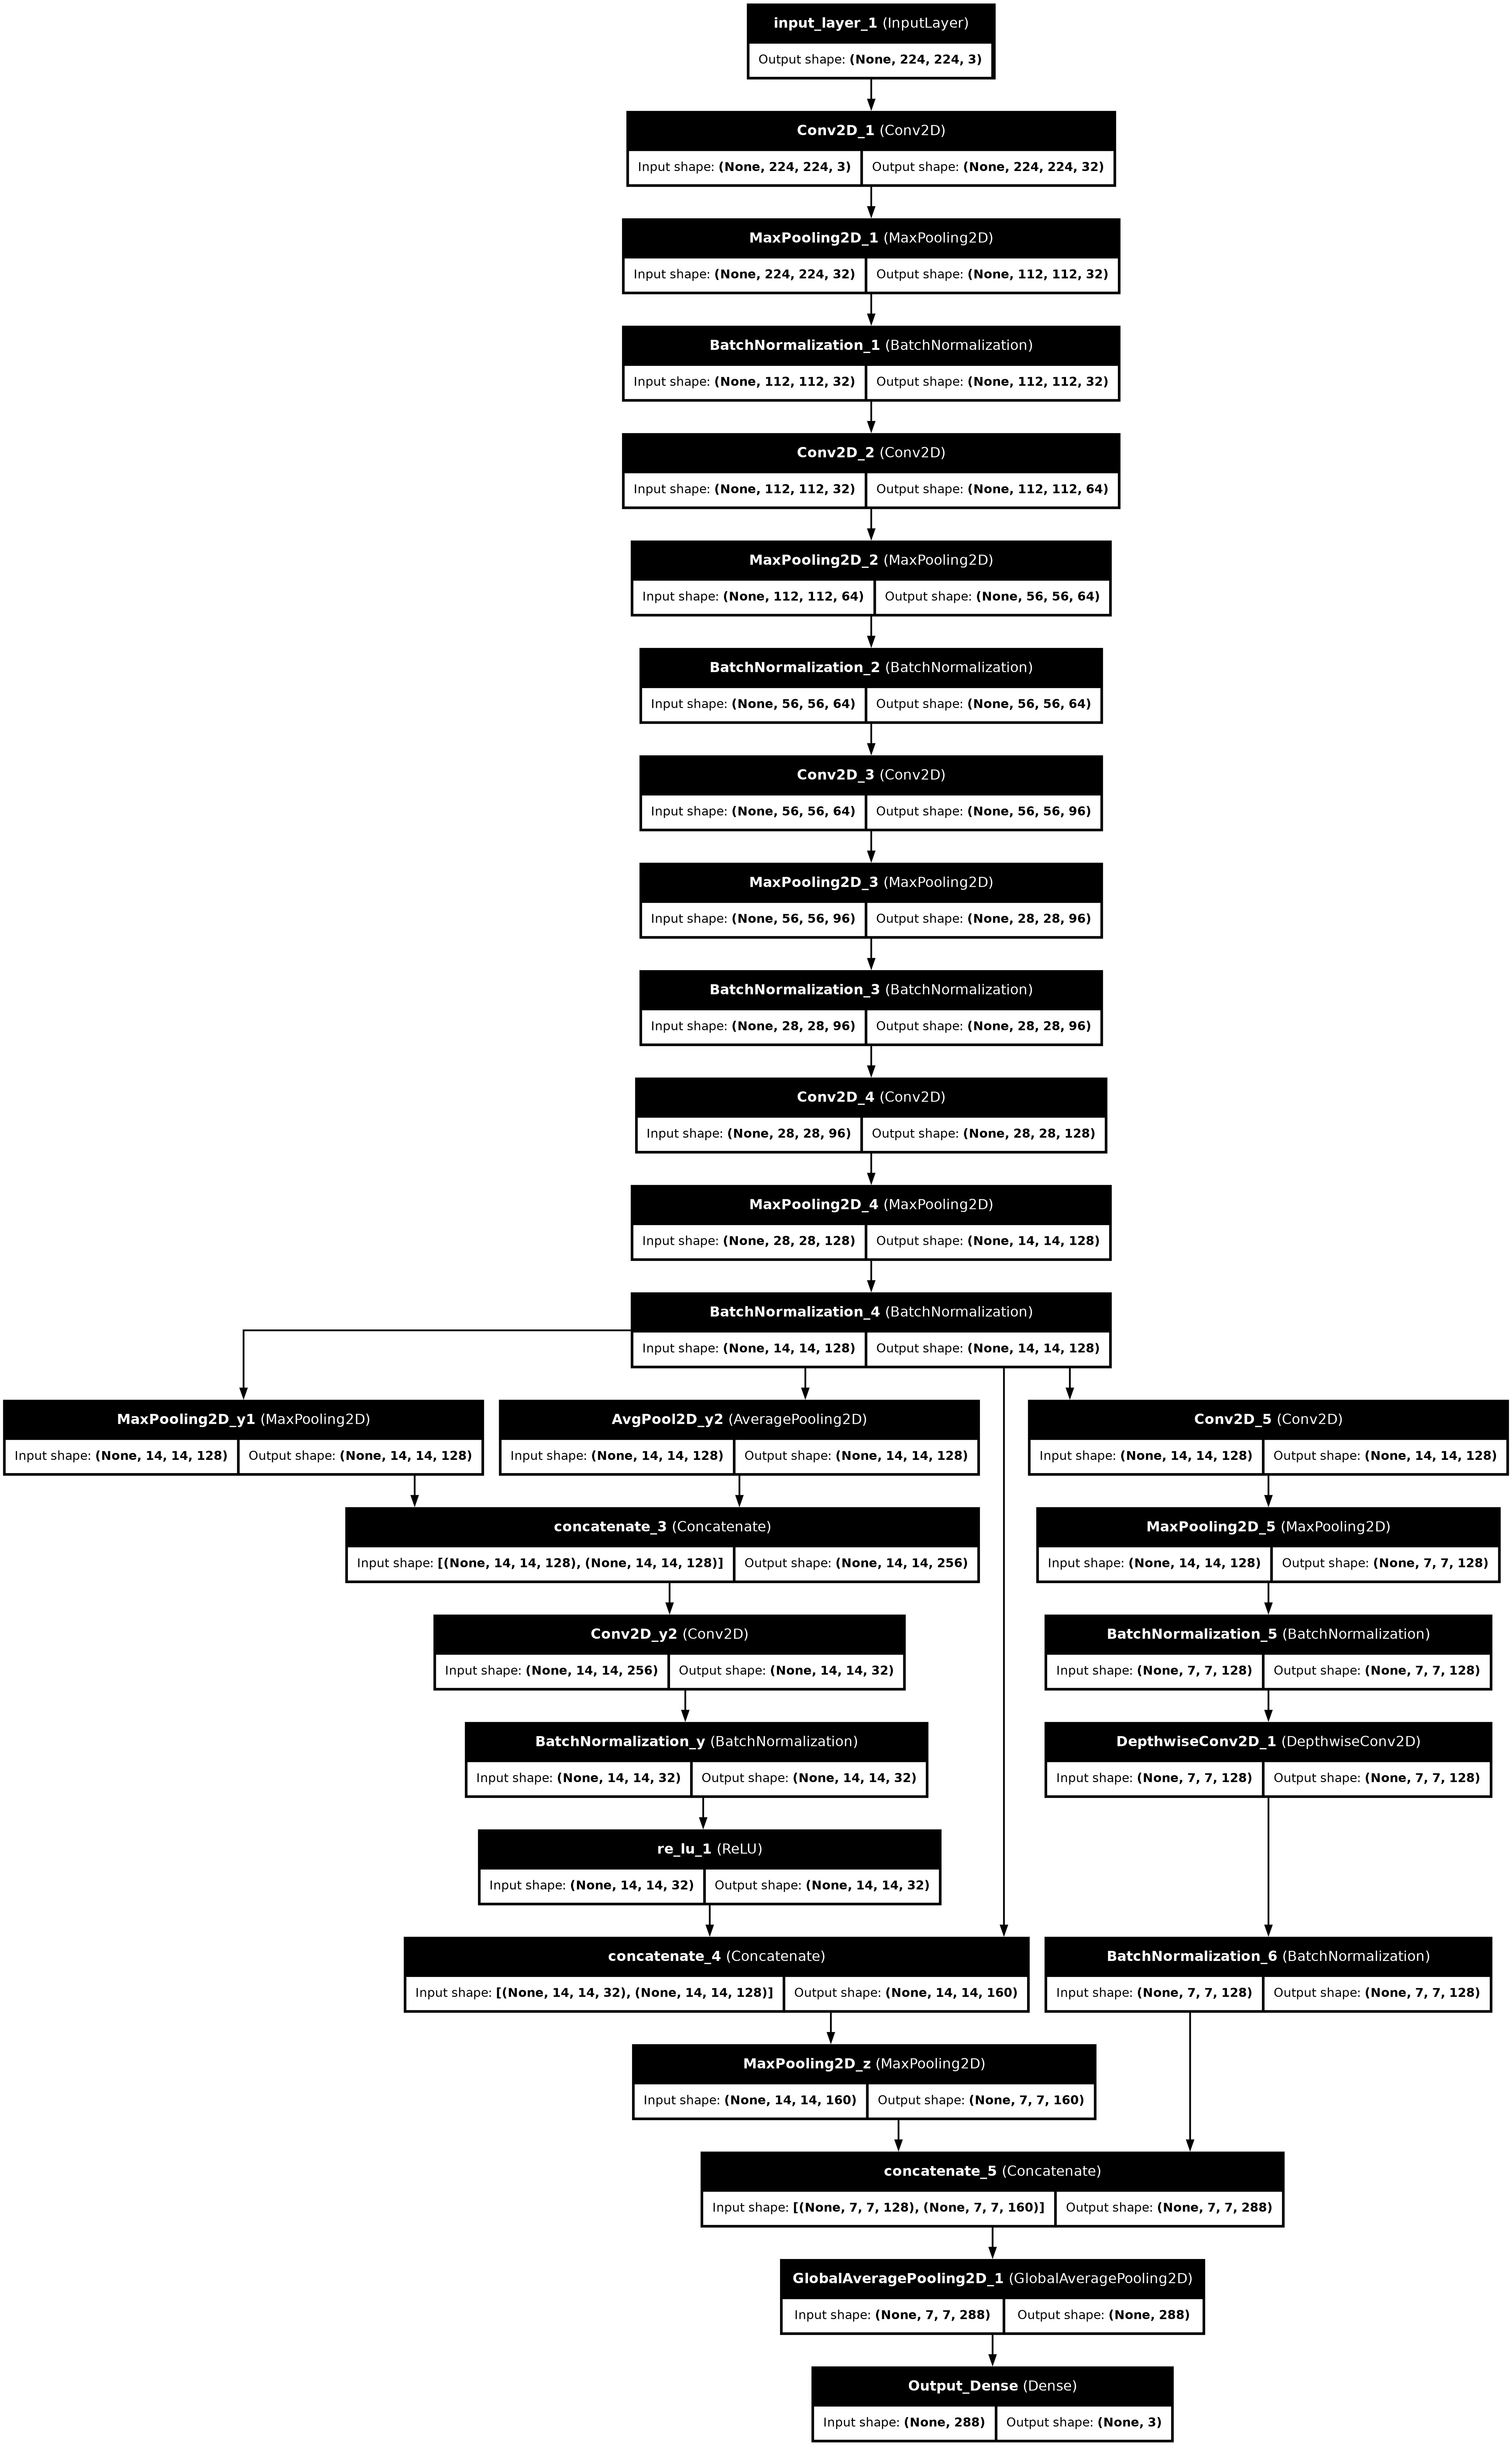

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [19]:
import tensorflow.keras.backend as K

def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return [
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    ]

In [26]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping
other_metrics = create_metrics()
metrics = []
metrics.append("accuracy")
metrics.extend(list(other_metrics))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics)

In [27]:
initial_learning_rate=0.0009

def lr_scheduler(epoch, lr):
    if epoch < 7:
      return lr
    else:
      return lr * 0.95

lr_callback = LearningRateScheduler(lr_scheduler)

In [28]:
from time import perf_counter

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

optimizer_ad = Adam(learning_rate=initial_learning_rate)

start_time = perf_counter()

history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[lr_callback, early_stopping_callback]
)
end_time = perf_counter()

Epoch 1/20


I0000 00:00:1727532608.824798     103 service.cc:145] XLA service 0x7a2b70004100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727532608.824864     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/260 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.4665 - auc_3: 0.6944 - f1_score: 0.3907 - loss: 1.0463 - mcc: 0.1680 - precision_3: 0.4769 - recall_3: 0.3453 - sensitivity: 0.3453 - specificity: 0.8104   

I0000 00:00:1727532616.609111     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.5768 - auc_3: 0.7834 - f1_score: 0.5376 - loss: 0.8307 - mcc: 0.3488 - precision_3: 0.6036 - recall_3: 0.4904 - sensitivity: 0.4904 - specificity: 0.8397 - val_accuracy: 0.6058 - val_auc_3: 0.8072 - val_f1_score: 0.6043 - val_loss: 0.8834 - val_mcc: 0.4119 - val_precision_3: 0.6152 - val_recall_3: 0.5933 - val_sensitivity: 0.5933 - val_specificity: 0.8144 - learning_rate: 0.0010
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7451 - auc_3: 0.9065 - f1_score: 0.7390 - loss: 0.5782 - mcc: 0.6193 - precision_3: 0.7726 - recall_3: 0.7095 - sensitivity: 0.7095 - specificity: 0.8957 - val_accuracy: 0.5702 - val_auc_3: 0.8567 - val_f1_score: 0.5681 - val_loss: 0.8672 - val_mcc: 0.3549 - val_precision_3: 0.5728 - val_recall_3: 0.5635 - val_sensitivity: 0.5635 - val_specificity: 0.7899 - learning_rate: 0.0010
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8779 - auc_3: 0.9717 - f1_score: 0.8754 - los

In [29]:
result = model.evaluate(X_test, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9912 - auc_3: 0.9999 - f1_score: 0.9912 - loss: 0.0251 - mcc: 0.9868 - precision_3: 0.9912 - recall_3: 0.9912 - sensitivity: 0.9912 - specificity: 0.9956


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
              precision    recall  f1-score   support

          CI       0.99      0.99      0.99       573
          AD       0.99      0.98      0.99       119
          CN       0.99      0.99      0.99       464

    accuracy                           0.99      1156
   macro avg       0.99      0.99      0.99      1156
weighted avg       0.99      0.99      0.99      1156



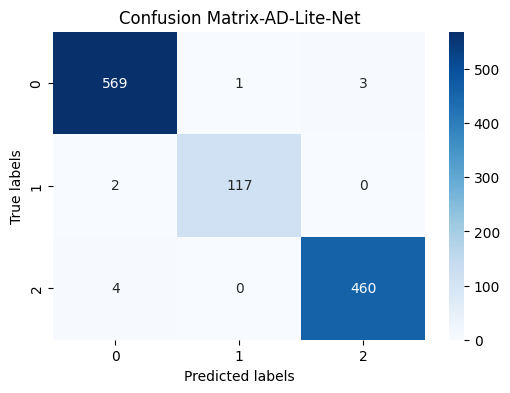

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make predictions
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(y_val_classes, y_pred_classes, target_names=mapped_dict_2.keys())

print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)

# Calculate true positives for each class
true_positives = np.diag(conf_matrix)

# Plot heatmap with true positives
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix-AD-Lite-Net')
plt.show()


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


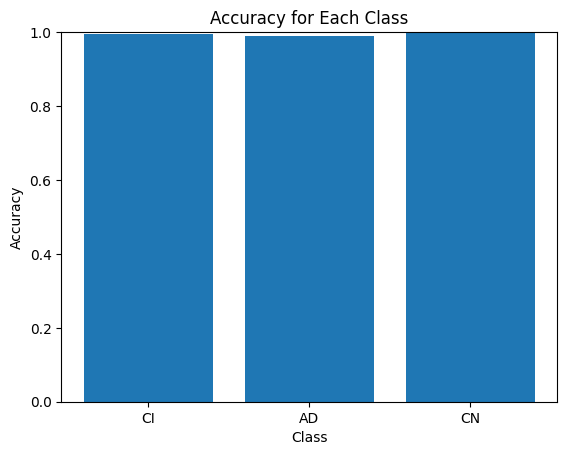

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Calculate the accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Plotting
plt.bar(mapped_dict_2.keys(), class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.ylim([0, 1])  # Set the limit of y-axis to [0,1] for percentage
plt.show()


In [32]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

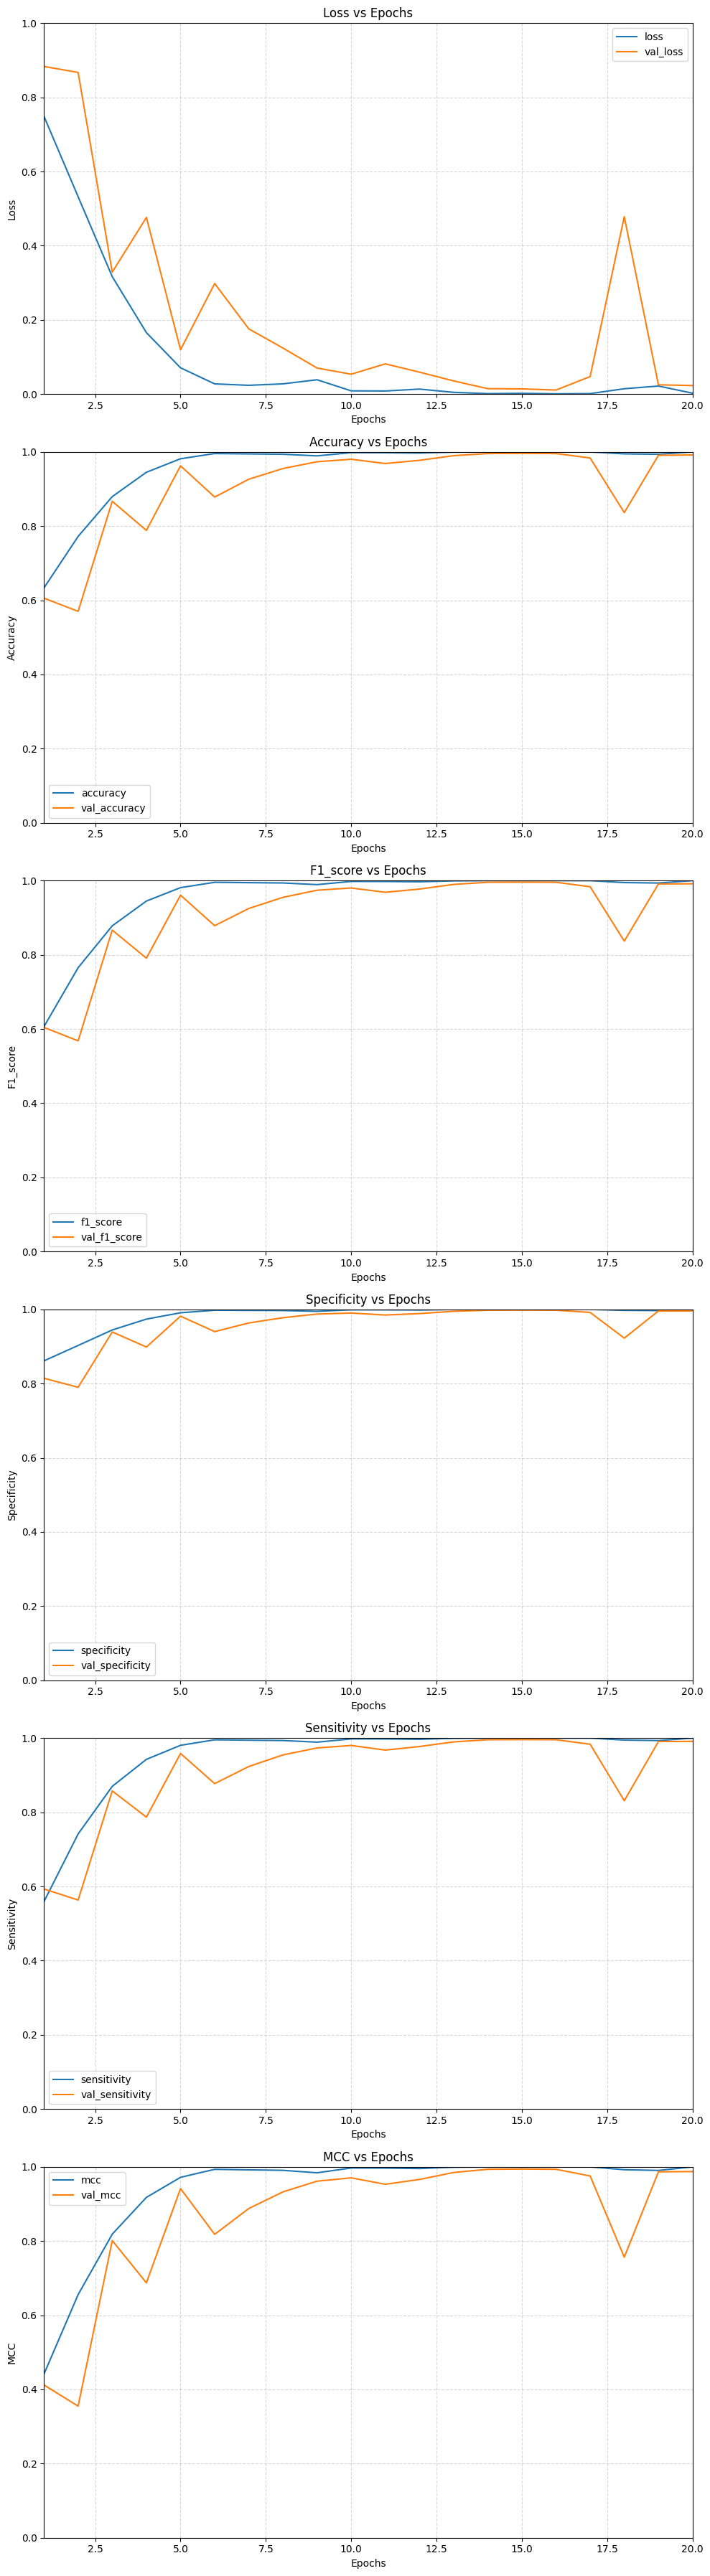

In [33]:
import math
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)

In [35]:
EXP_NAME = "SAM"
pd.DataFrame(history.history).to_csv(f"/kaggle/working/{EXP_NAME}_fold_{fold_number}.csv")